In [ ]:

# install all dependencies
!pip install pytube
!pip install python-dotenv

!pip install torch torchvision torchaudio
!pip install transformers
!pip install sentencepiece

!pip install openai

!pip install --ignore-installed PyYAML
!pip install langchain



In [3]:
# import secrets
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ASSEMBLYAI_API_SECRET = os.getenv("ASSEMBLYAI_API_SECRET")


**AssemblyAI Helper functions**

In [7]:
# AssemblyAI integration
import requests
import json
import time

assemblyAI_base_url = "https://api.assemblyai.com/v2"

assemblyAI_headers = {
  "authorization": ASSEMBLYAI_API_SECRET,
}

# upload file to assemblyAI
def upload_file(filename):
  with open(filename, "rb") as f:
    upload_url = assemblyAI_base_url + "/upload"
    response = requests.post(upload_url, headers=assemblyAI_headers, data=f)

  upload_url = response.json()["upload_url"]
  return upload_url

# transcribe the file
def create_transcript(upload_url):
  transcribe_url = assemblyAI_base_url + "/transcript"
  data = {
    "audio_url": upload_url
  }
  response = requests.post(transcribe_url, json=data, headers=assemblyAI_headers)

  transcript_id = response.json()['id']
  polling_url = transcribe_url + "/" + transcript_id

  while True:
    transcription_result = requests.get(polling_url, headers=assemblyAI_headers).json()

    if transcription_result['status'] == 'completed':
      result = transcription_result['text']
      return result

    elif transcription_result['status'] == 'error':
      raise RuntimeError(f"Transcription failed: {transcription_result['error']}")

    else:
      time.sleep(3)

**Step 0: Process the input file**

In [ ]:
import csv

videos = []

with open('videos.csv', mode='r') as csv_file:
  csv_reader = csv.DictReader(csv_file)
  line_count = 0
  for row in csv_reader:
    if line_count == 0:
      line_count += 1
    videos.append(row)
    line_count += 1
print(videos)

**Step 1: Download and transcribe videos**

In [ ]:

import os
from pytube import YouTube

def transcribe_video(video_url):
  # download the video
  yt = YouTube(video_url)
  audio = yt.streams.filter(only_audio=True).first()
  file_id = yt.video_id
  video_file = './videos/' + file_id + '.mp3'
  text_file = './transcripts/' + file_id + '.txt'
  
  if not os.path.exists(video_file):
    print(f'Downloading video id {file_id}')
    out_file = audio.download(filename=file_id)
    os.rename(out_file, video_file)

  if not os.path.exists(text_file):
    print(f'Uploading video id {file_id} to assemblyAI')
    # upload the file to assemblyAI
    upload_url = upload_file(video_file)

    # transcribe the file
    print(f'Generating transcript of video id {file_id}')
    transcript = create_transcript(upload_url)
    f = open(text_file, 'w')
    f.write(transcript)
    f.close()

for video in videos:
  transcribe_video(video['link'])


**Step 2a: Create an abstractive summary of the transcript using Google’s PEGASUS model**

In [11]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

In [12]:
# load tokenizer
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')

In [13]:
# load model
model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')

In [ ]:

def generate_summary(text):
  tokens = tokenizer(text, truncation=True, padding='longest', return_tensors='pt')
  summary_tokens = model.generate(**tokens)
  summary = tokenizer.decode(summary_tokens[0])
  return summary

for video in videos:
  # read the video transcript
  video_id = video['link'].split('=')[1]
  transcript_file = open('./transcripts/' + video_id + '.txt', 'r')
  video_transcript = transcript_file.read()

  summary_file = './summaries/pegasus-' + video_id + '.txt'
  if not os.path.exists(summary_file):
    print(f'Pegasus: Generating summary of video id {video_id}')

    # run the summary generation workflow
    summary = generate_summary(video_transcript)

    # save summary to file
    f = open(summary_file, 'w')
    f.write(summary)
    f.close()

In [17]:
# clean up the summary data generated by Pegasus
import re
CLEANR = re.compile('<.*?>') 

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

for video in videos:
  video_id = video['link'].split('=')[1]
  summary_file = open('./summaries/pegasus-' + video_id + '.txt', 'r')
  summary = summary_file.read()
  summary = cleanhtml(summary)
  clean_summary_file = open('./summaries/pegasus-' + video_id + '-clean.txt', 'w')
  clean_summary_file.write(summary)
  clean_summary_file.close()

**Step 2b: Create an abstractive summary of the transcript using OpenAI's GPT-3 model**


In [ ]:
import openai

openai.api_key = OPENAI_API_KEY

# split the video transcript into chunks of 2048 characters
def split_text(text):
  max_chunk_size = 2048
  chunks = []
  current_chunk = ''
  for sentence in text.split('.'):
    if len(current_chunk) + len(sentence) < max_chunk_size:
      current_chunk += sentence + '.'
    else:
      chunks.append(current_chunk.strip())
      current_chunk = sentence + '.'
  if current_chunk:
    chunks.append(current_chunk.strip())
  return chunks

# generate summary using openai
def generate_summary(text):
  input_chunks = split_text(text)
  output_chunks = []
  for chunk in input_chunks:
    response = openai.Completion.create(
      engine="davinci",
      prompt=(f"Please summarize the following text: {chunk}\n"),
      temperature=0.5,
      max_tokens=1024,
    )
    summary = response.choices[0].text.strip()
    output_chunks.append(summary)
  return ''.join(output_chunks)


for video in videos:
  # read the video transcript
  video_id = video['link'].split('=')[1]
  transcript_file = open('./transcripts/' + video_id + '.txt', 'r')
  video_transcript = transcript_file.read()

  summary_file = './summaries/openai-' + video_id + '.txt'
  if not os.path.exists(summary_file):
    print(f'OpenAI: Generating summary of video id {video_id}')

    # run the summary generation workflow
    summary = generate_summary(video_transcript)

    # save summary to file
    f = open(summary_file, 'w')
    f.write(summary)
    f.close()


**Step 3: Create embeddings of the transcript summary**

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
import openai
import csv

openai.api_key = OPENAI_API_KEY

def create_embeddings(video_id, summary_path):
  data_path = './data/' + summary_path + video_id + '.csv'
  if not os.path.exists(data_path):
    with open(data_path, 'w') as csv_file:
      csv_writer = csv.writer(csv_file)

      # write the header
      csv_writer.writerow(['video_id', 'text', 'embedding'])

      # write the data rows
      with open('./summaries/' + summary_path + video_id + '.txt') as text_file:
        summary = text_file.read()
        text_splitter = RecursiveCharacterTextSplitter(
          chunk_size = 2048,
          chunk_overlap  = 20,
        )
        documents = text_splitter.create_documents([summary])

        for text in documents:
          embedding=openai.Embedding.create(model="text-embedding-ada-002", input=text.page_content)
          query_result=embedding['data'][0]['embedding']
          csv_writer.writerow([video_id, text.page_content, query_result])

# generate embeddings for the openai summaries
summary_path='openai-'
for video in videos:
  video_id = video['link'].split('=')[1]
  print(f'OpenAI: Generating embeddings for video id {video_id}')
  create_embeddings(video_id, summary_path)

# generate embeddings for the pegasus summaries
summary_path='pegasus-'
for video in videos:
  video_id = video['link'].split('=')[1]
  print(f'Pegasus: Generating embeddings for video id {video_id}')
  create_embeddings(video_id, summary_path)
 

**Step 4: Categorization**

In [10]:
import openai
import csv

# obtain embeddings of the labels
data_file = './data/categories.csv'
if not os.path.exists(data_file):
  with open(data_file, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['category', 'embedding'])
    for category in categories:
      print(f'Generating embeddings for category {category}')
      embedding=openai.Embedding.create(model="text-embedding-ada-002", input=category)
      query_result=embedding['data'][0]['embedding']
      csv_writer.writerow([category, query_result])
    

Generating embeddings for category finance
Generating embeddings for category food
Generating embeddings for category travel


In [25]:
# classify videos into categories
categories = ['finance', 'food', 'travel']

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy import spatial

# read category embeddings
category_df = pd.read_csv('./data/categories.csv')
category_df["embedding"] = category_df.embedding.apply(eval).apply(np.array)
category_matrix = np.vstack(category_df.embedding.values)
print('category matrix shape: ', category_matrix.shape)

# nearest neighbors fit
neighbors = NearestNeighbors(n_neighbors=1, metric=spatial.distance.cosine)
neighbors.fit(category_matrix)

embeddings = np.empty((0, 1536), float) # todo: change hardcoded number

# read data embeddings
for video in videos:
  video_id = video['link'].split('=')[1]
  datafile_path = './data/' + video_id + '.csv'
  df = pd.read_csv(datafile_path)
  df["embedding"] = df.embedding.apply(eval).apply(np.array)
  matrix = np.vstack(df.embedding.values)

  # append the matrix to the embeddings
  embeddings = np.vstack((embeddings, matrix))
  
  # compute the centroid of summary embeddings
  centroid = embeddings.mean(axis=0)
  
  # classify using KNN
  index = neighbors.kneighbors([centroid], return_distance=False)[0, 0]
  category = categories[index]
  print('category: ', category)

category matrix shape:  (3, 1536)
category:  finance
category:  food
category:  food


**Step 4: Clustering**

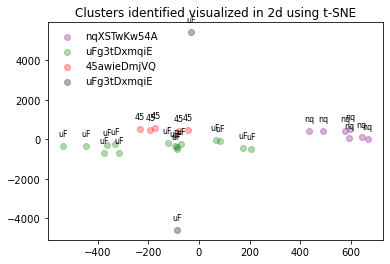

In [45]:
import numpy as np
import pandas as pd

# TODO: use the csv data to generate the clusters

embeddings = np.empty((0, 1536), float) # todo: change hardcoded number
embeddings_df = pd.DataFrame()

for video in videos:
  video_id = video['link'].split('=')[1]
  datafile_path = './data/' + video_id + '.csv'
  df = pd.read_csv(datafile_path)
  df["embedding"] = df.embedding.apply(eval).apply(np.array)
  matrix = np.vstack(df.embedding.values)

  # append the matrix and df to the embeddings
  embeddings = np.vstack((embeddings, matrix))
  embeddings_df = embeddings_df.append(df)

from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(embeddings)
labels = kmeans.labels_
embeddings_df['cluster'] = labels

from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=3, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(embeddings)

x_coords = [x for x, y in vis_dims2]
y_coords = [y for x, y in vis_dims2]

legend_map = {}

for category, color in enumerate(["purple", "green", "red", "black"]):
  xs = np.array(x_coords)[np.where(embeddings_df['cluster'] == category)[0]]
  ys = np.array(y_coords)[np.where(embeddings_df['cluster'] == category)[0]]
  # get the video id for this category of points
  vid_id = embeddings_df.loc[(embeddings_df['cluster'] == category), 'video_id'].iloc[0]

  # plot the points 
  plt.scatter(xs, ys, color=color, alpha=0.3, label=None)

  # create a map of color to video id for the legend
  legend_map[color] = vid_id

  # label points with their video_id
  for x,y in zip(xs,ys):
    label = vid_id[:2]

    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
  
for color in legend_map:
  plt.scatter([], [], c=color, alpha=0.3, label=legend_map[color])

plt.legend(loc="upper left", scatterpoints=1, frameon=False, labelspacing=0.5)
plt.title("Clusters identified visualized in 2d using t-SNE")
plt.savefig('images/categories.png')

  
